In [2]:
'''
filepath will point to current location of the Jupyter Notebook. Creates a folder for downloading data into, and another for figures.
'''
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('data'):
    os.mkdir('data')
else:
    print("'data' directory already exists'")
if not os.path.exists('figures'):
    os.mkdir('figures')
else:
    print("'figures' directory already exists'")
filepath = os.getcwd()

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk
'data' directory already exists'
'figures' directory already exists'


In [63]:
'''
Import packages
'''
from netCDF4 import Dataset
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import patheffects, rc, rcParams
from matplotlib.ticker import LogFormatterExponent
import matplotlib as matplotlib

plt.rcParams["font.family"] = 'serif'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text', usetex=True)

from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import string as STRING
import warnings
warnings.filterwarnings('ignore')

print("All packages imported")

All packages imported


In [8]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)

'''
Defines a few colours used later
'''
vir_b = plt.cm.viridis_r(255)
vir_g = plt.cm.viridis_r(127.5)
vir_y = plt.cm.viridis_r(0)

'''
For formatting logarithmic axis labels
'''
class LogFormatterTexTextMode(LogFormatterExponent):
    def __call__(self, x, pos=None):
        x = LogFormatterExponent.__call__(self, x,pos)
        s = r"10\textsuperscript{{{}}}".format(x)
        return s

## The following code snippets download and extract data from NASA's Earth Observing System Data and Information System "EARTHDATA" portal. These data should be cited appropriately (https://doi.org/10.5067/TRMM/TMPA/3H/7) ##
1. First we create a text file with filenames within a particular date range (set via ```start_date``` and ```end_date```);
2. The data files are then downloaded iteratively into the ```data``` folder. Note that you may not want to store these files locally. In this case, you should modify the query to use the ```OPeNDAP``` format rather than downloading hundreds of large ```NetCDF``` files;
3. The rainfall information is extracted from files.

In [10]:
'''
Generate 'data_url.txt' file with list of urls required for data download. The default is to download all data from 01 Mar 2000 up until yesterday. 
A window of dates can be entered instead, for example: 

data_range(first=dt.date(2018, 12, 15), last=dt.date(2018,12,18))

'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data

prefix = 'https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_RT/TRMM_3B42RT_Daily.7/'

suffix = '.7.nc4\n'

yesterday = dt.date.today() - timedelta(1)

start_date = dt.date(2000, 3, 1)
end_date = dt.date(2019, 12, 31)

def data_range_string(first = None, last = end_date):
    data_dates = last - first
    for j in range(data_dates.days + 1):
        yield (first + timedelta(days = j)).strftime('%Y/%m')+'/3B42RT_Daily.'+(first + timedelta(days = j)).strftime('%Y%m%d')


string_list = list(data_range_string(first = start_date))#, last=dt.date(2018,12,18)))

with open("data_url.txt", "w") as output:
    for line in list([ prefix+x+suffix for x in string_list ]):
        output.write(str(line))

In [11]:
'''
Access and download data files specified in data_url using wget. Will skip previously downloaded files.

Note: despite -nv, will be verbose if large number of new datafiles are being accessed. 
Right-click on cell and Enable Scrolling for Outputs, if necessary. One can change -nv to -q, but it may be useful to have some output.
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
!wget -nv -i data_url.txt -nc -c 
print('Data retrieved')

Data retrieved


In [12]:
import datetime as dt
'''
Opens textfile with list of data urls. Removes useless characters and returns a list of filenames for later use, as well as a list of dates. 
'''
if os.getcwd() != filepath+'/data':
    %cd $filepath/data
datafile = 'data_url.txt'
f = open(datafile)
f.seek(0)
fileIDs = f.readlines()
f.close()
fileIDs = [line.rstrip('\n') for line in fileIDs]
fileIDs = [line.lstrip(prefix) for line in fileIDs]
file_list =[]
for j,k in enumerate(fileIDs):
    text = fileIDs[j]
    if text.endswith('nc4'):    # Only deals with files that are netcdf format
        file_list.append(fileIDs[j][7:])
    else:
        continue
file_names = []
for j,k in enumerate(file_list):
    file_names.append(file_list[j][13:21])
fd =[]
for j,k in enumerate(file_names):
    fd.append(file_names[j][0:4]+'-'+file_names[j][4:6]+'-'+file_names[j][6:])
file_dates = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in fd]
print("Dates available : {} to {}".format(file_dates[0], file_dates[-1]))

Dates available : 2000-03-01 to 2019-12-31


In [13]:
'''
Open netcdf files and extract information.
'''

if os.getcwd() != filepath+'/data':
    %cd $filepath/data
    
ncFid = Dataset(file_list[0],"r", format = "NETCDF4") # Open just the first file to extract latitude and longitude data
longitude = ncFid.variables['lon'][:]
latitude = ncFid.variables['lat'][:]
ncFid.close() # Close file once done

precipitation = [] # Create precipitation variable
start_dates = [] # Create date variable
m = -1
for j,k in enumerate(file_list): # Interrogates file_list as defined above
    ncFid = Dataset(file_list[j],"r", format = "NETCDF4")
    precipitation.append(np.transpose(ncFid.variables['precipitation'][:])) # Iteratively append precipitation data
    start_dates.append(np.transpose(ncFid.BeginDate)) # Iteratively append date information
    ncFid.close() # Close file before opening next
    if j % int(np.ceil(len(file_list)/100)) == 0:
        m += 1
        print('{:02d}% | '.format(np.arange(1,101)[m]), sep=' ', end=' ', flush=True)
print("{} dates".format(len(precipitation)))        

01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  7245 dates


In [14]:
file_dates = file_dates[0:len(precipitation)]

## This script was initially written with the view of investigating rainfall in volcanic environments (see, e.g., https://doi.org/10.1038/s41586-020-2172-5). The following code blocks access the most up-to-date volcano information from the Smithsonian Institution (https://volcano.si.edu/volcano.cfm?vn=332010). Latitude and longitude data for a given volcano of interest are extracted for use later.

In [17]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")
volcanoes = list(set(eruption_list.Volcano_Name))
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.'.format(
    len(volcano_list),len(eruption_list),len(volcanoes)))                           

--2021-01-12 15:34:06--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [              <=>   ]   2.02M   702KB/s    in 3.0s    

2021-01-12 15:34:09 (702 KB/s) - ‘Holocene_eruptions.csv’ saved [2123164]

--2021-01-12 15:34:09--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volca

In [18]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Adds longitudes to original dataframe
print('Done\nand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locationlist = locations.values.tolist
print('Done')

Done
and
Done


In [19]:
'''
Creates dataframe with eruption information for all active volcanoes
'''
volcano_countries = volcano_list.set_index('Country')
all_active_volcanoes = pd.merge(eruption_list,volcano_countries, how = 'inner', on = ['Volcano_Name'])

'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

volcano_set_name = []
volcano_set_lat = []
volcano_set_lon = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in volcano_set_name:
        volcano_set_name.append(k)
        volcano_set_lat.append(all_active_volcanoes.lats[j])
        volcano_set_lon.append(all_active_volcanoes.lons[j])

volcano_set = pd.DataFrame({'Name' :volcano_set_name,'lat' : volcano_set_lat, 'lon' : volcano_set_lon})
volcano_set.set_index('Name', inplace = True)

In [20]:
'''
Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
and typically correspond to the summit or centre of the caldera region.
'''
name_volc = 'Pacaya'
lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
lon_volc = volcano_set.loc[[name_volc]].lon.values[0]

j_volc = min(longitude, key=lambda x:abs(x-lon_volc))
i_volc = min(latitude, key=lambda x:abs(x-lat_volc))

In [21]:
'''
Append precipitation data from TRMM/ GPM data for geolocation 
(i.e. lat/lon defined by i_volc and j_volc.)
'''
rainfall = []
for j,k in enumerate(precipitation):
    rainfall.append(precipitation[j][list(latitude).index(i_volc)][list(longitude).index(j_volc)])

In [22]:
'''
Rainfall added to datafraame
'''
rain_dates = pd.DataFrame( # dataframe containing "pentad" data (five-day running mean), for later use
    {'date':file_dates[:],
     'rainfall': rainfall
    })
j = 5
pentads = rain_dates.rainfall.rolling(j).mean()
pentads.fillna(0, inplace=True)
rainfall_m=rain_dates.rainfall/1e3 # rainfall in meters

In [23]:
''' 
Creates and fills the "raindf" dataframe, which stores much of the information required for further time-series analysis etc. 
'''
raindf = pd.DataFrame(
    {'date':file_dates, ##
     'monthly_cumulative_mm': rainfall
    })
raindf.date = pd.to_datetime(raindf.date)
raindf = raindf.groupby('date').monthly_cumulative_mm.max()
raindf = raindf.groupby(raindf.index.to_period('M')).cumsum().reset_index()
raindf['daily_rainfall_mm'] = rainfall
raindf['mnth_yr'] = raindf.date.dt.to_period('M')
raindf['mnth'] = raindf.date.dt.month
raindf['day'] = raindf.date.dt.dayofyear
raindf['year'] = raindf.date.dt.year

threshold = 10
raindf['masked'] = raindf.monthly_cumulative_mm.mask(raindf.monthly_cumulative_mm < threshold)
raindf.index = raindf['date']
raindf[0:2]

,date,monthly_cumulative_mm,daily_rainfall_mm,mnth_yr,mnth,day,year,masked
date,,,,,,,,
2000-03-01,2000-03-01,0.63,0.63,2000-03,3,61,2000,NaN
2000-03-02,2000-03-02,2.16,1.53,2000-03,3,62,2000,NaN


In [24]:
'''
Total monthly rainfall values are calculated from 'raindf' and added to a new dataframe 'mnth_raindf'.
'''
year_mnth = sorted(set(raindf.mnth_yr))
monthly_sum = raindf.daily_rainfall_mm.groupby(raindf.mnth_yr).sum()
'''
Creates dataframe to manipulate monthly data
'''
mnth_raindf = pd.DataFrame(
    {'year_mnth':year_mnth,
     'monthly_sum':monthly_sum
    })
mnth_raindf.index = mnth_raindf.index.to_timestamp()

avgs = []
for k in (mnth_raindf.index.month):
    avgs.append(mnth_raindf.loc[mnth_raindf.index.month == k].monthly_sum.mean())
mnth_raindf['avg'] = avgs
mnth_raindf['differ'] = mnth_raindf.monthly_sum - mnth_raindf.avg
print("Done")

Done


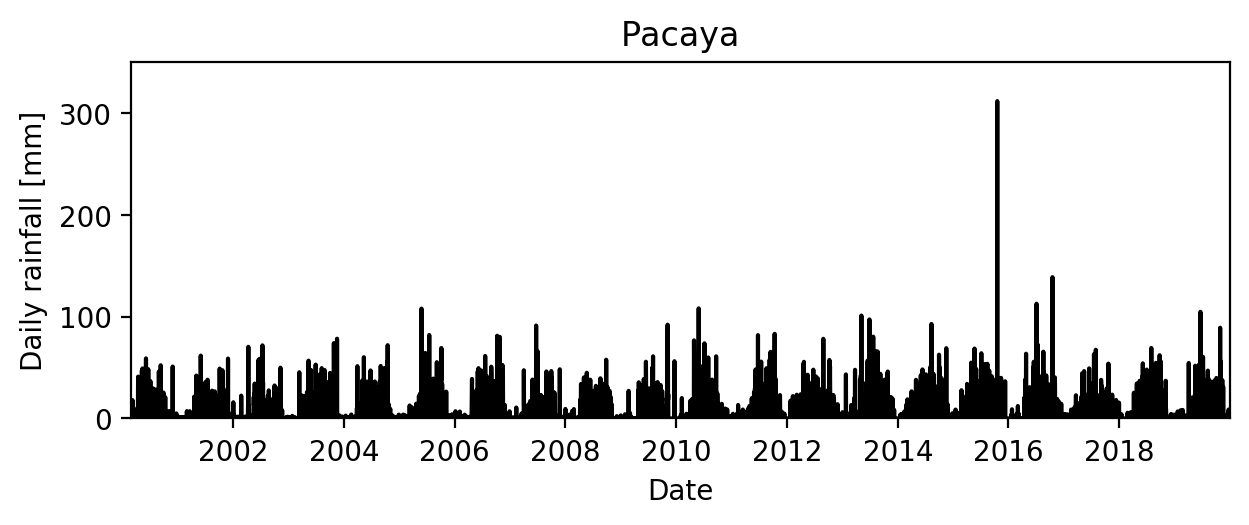

In [38]:
fig = plt.figure(figsize=mm2inch(180, 60), dpi = 200) ## initiate figure 
ax = fig.add_subplot(111)
ax.plot(raindf.daily_rainfall_mm, color = "k")
ax.set(ylabel = "Daily rainfall [mm]",
      xlabel = "Date",
      ylim = [0,350],
       xlim = [min(file_dates),max(file_dates)],
      title = name_volc)
plt.show()

**Figure 1 |** Rainfall over volcano of interest.

In [34]:
'''
Calculates cumulative rainfall amounts for rolling windows of 30, 90, 120, and 180 days.
Not necessary unless further processing of the data is required.
'''

rainfalldf = pd.DataFrame({"date": file_dates, "rain": rainfall})

rainfalldf["roll30"] = rainfalldf.rain.rolling(30).sum()
rainfalldf["roll90"] = rainfalldf.rain.rolling(90).sum()
rainfalldf["roll120"] = rainfalldf.rain.rolling(120).sum()
rainfalldf["roll180"] = rainfalldf.rain.rolling(180).sum()

rainfalldf["log30"] = np.log(rainfalldf.roll30)
rainfalldf["log90"] = np.log(rainfalldf.roll90)
rainfalldf["log180"] = np.log(rainfalldf.roll180)

rainfalldf["cum"] = rainfalldf.rain.cumsum() 

In [42]:
''' Create a buffer path effect for plotting '''
# from matplotlib import patheffects
buffer = [patheffects.withStroke(linewidth=.85, foreground="w")]

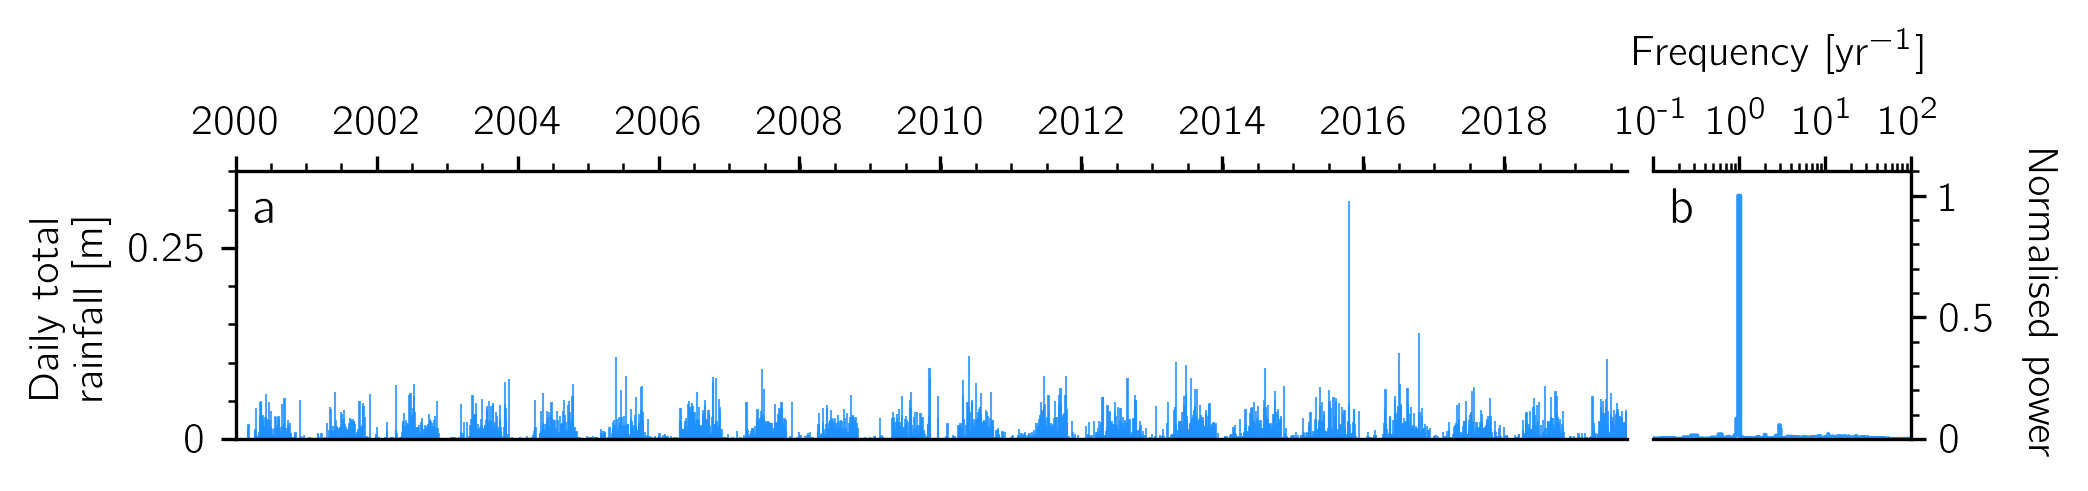

In [62]:
'''
Plots Figure 2 based on processed rainfall data.
'''
fig = plt.figure(figsize=mm2inch(183, 30), dpi = 300) ## initiate figure 
gs = plt.GridSpec(1, 6, figure=fig, wspace=0.1) ## define axes 
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) ## set up logarithmic axis options
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.arange(0.1,1,0.1)),numticks=12)

axs = [fig.add_subplot((gs[0, :-1])), ## add axes to figure
        fig.add_subplot(gs[0, -1]),
       ]

ys = np.arange(-2000,2100,0.5)
xax1 = ["2018-01-01" for y in ys]
xax2 = ["2018-03-31" for y in ys]

################ panel a ###############
## bar chart of daily rainfall 
axs[0].bar(file_dates,rainfall_m,
           color="dodgerblue",
           linewidth = .5,
           edgecolor = "dodgerblue",alpha =0.8)
axs[0].set_xlim(min(file_dates), max(file_dates))
axs[0].set_ylim(0, .35)#max(rainfall_m))
axs[0].set_ylabel('Daily total\nrainfall [m]')
axs[0].set_yticks([0,.25])
axs[0].spines['right'].set_visible(False)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[0].yaxis.set_major_formatter(ticks_y)
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].set_xlim("2000-01-01", "2019-10-01")
axs[0].minorticks_on()
################ panel a ###############

############### panel b ###############
## Processes rainfall time-series and plots as a power spectrum.
A = np.fft.fft(pentads) ## Fast Fourier transform
B = np.abs(A)**2

n = pentads.size
freq = np.fft.fftfreq(n, d= 1/365.25) ## Fast Fourier transform
k = freq > 0

axs[1].set_xlim(0.1,100)
axs[1].set_ylim(0,1.1)
axs[1].step(freq[k],B[k]/max(B[k]),
            color = 'dodgerblue',
            linestyle = 'solid',
            linewidth =1, alpha = 0.95, where = 'mid') # Normalised power versus frequency
plt.minorticks_on()

axs[1].set_ylabel("Normalised power", rotation = 270, labelpad = 15)
axs[1].set_xlabel(r'Frequency [yr$^{-1}$]', labelpad = 10)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
axs[1].yaxis.set_major_formatter(ticks_y)
axs[1].xaxis.set_major_formatter(ticks_y)

axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right') 
axs[1].set_xscale("log")
axs[1].xaxis.set_major_formatter(LogFormatterTexTextMode())
axs[1].xaxis.set_major_locator(locmaj)
axs[1].xaxis.set_minor_locator(locmin)
axs[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axs[1].set_xticks([0.1,1,10,100])

axs[1].spines["left"].set_visible(False)
################ panel b ###############



## Add axis labels and clean up plot
for num, label in enumerate(STRING.ascii_lowercase[0:2]):
    axs[num].annotate(label, (0, 1),xytext=(4, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)

plt.tight_layout()
# plt.savefig(filepath+"/figures/{}_rainfall.png".format(name_volc), bbox_inches="tight") ## save figure as image format
# plt.savefig(filepath+"/figures/{}_rainfall.pdf".format(name_volc), bbox_inches="tight") ## save figure as vector format

plt.show()


**Figure 2 |** Rainfall over volcano of interest. a Satellite-derived daily rainfall amount from Mar 2000 to July 2019 (TRMM/GPM data). b Power spectrum of Fourier-transformed rainfall time-series (a) shown in the (normalised) power–frequency domain.

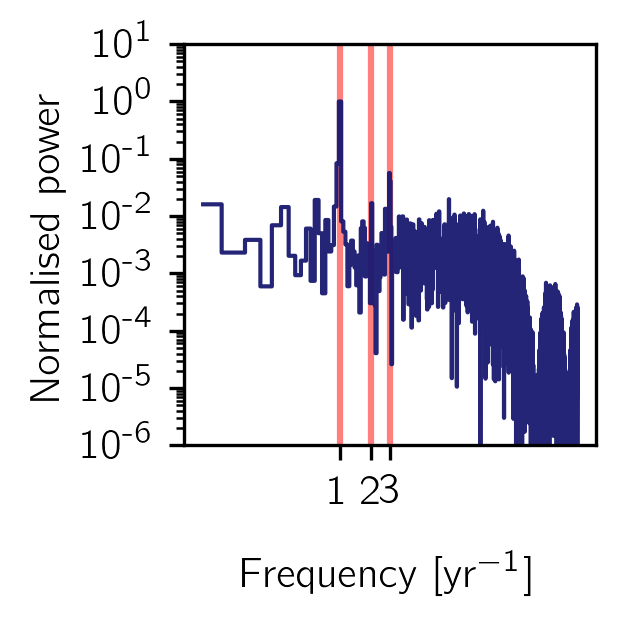

In [81]:
fig = plt.figure(figsize=mm2inch(45, 45), dpi = 300) ## initiate figure 
ax = fig.add_subplot(111)
plt.step(freq[k],B[k]/max(B[k]),
            color = 'midnightblue',
            linestyle = 'solid',
            linewidth =1, alpha = 0.95, where = 'mid')
plt.yscale("log")
plt.xscale("log")
for i in range(4):
    plt.axvline(i, color = "r", zorder = 0, lw = 1.5, alpha = .5)

plt.minorticks_on()

ax.set_ylabel("Normalised power")
ax.set_xlabel(r'Frequency [yr$^{-1}$]', labelpad = 10)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
ax.xaxis.set_major_formatter(ticks_x)
ax.set_ylim(1e-6, 1e1)

ax.yaxis.set_major_formatter(LogFormatterTexTextMode())
ax.yaxis.set_major_locator(locmaj)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1,2,3])

plt.show()

**Figure 3 |**  Power spectrum of Fourier-transformed rainfall time-series shown in the (normalised) power–frequency domain. In this example (Pacaya), a significant annual periodicity can be seen, as well as subordinate semiannual periodicity.